# Example for the `Speech-To-Text (STT)` API

This notebook illustrates how to build a pretrained `Whisper` model, and use it to transcribe an audio file !

Models are converted, from either the official `openai` checkpoints, either from the `transformers` models checkpoints, from `pytorch` to a `keras` instance. For this purpose, both your keras backend, and `torch` have to be installed. Once the model has been converted, `torch` is not required anymore ;) 

The `tts` method works on both audios and videos !

## Build whisper

[Whisper](https://github.com/openai/whisper) is a multilingual `Speech-to-Text` model trained by `OpenAI`.

**Note** : `pytorch` is required to convert the official `pytorch` checkpoint to a `keras` checkpoint ;)

**Note** : the tokenizer is now copied from the `transformers` library, as the new official `openai`'s code is using their custom `tiktoken` tokenizer. This means that the 2 tokenizers are not *exactly* identical, but are compatible as the differences do not have any impact on the model.

There is 2 supported versions of `Whisper` for inference :
- The `keras` implementation provided in `architectures/transformers/whisper_arch.py`
- The [TensorRT-LLM](https://github.com/NVIDIA/TensorRT-LLM) implementation

To get the best inference performances, the second option is the best one. The first implementation in `keras` is still maintained as it is a good way to effectively understand how `Whisper` is implemented, and working. It is worth mentioning that the provided `keras` implementation is faster than the `pytorch` implementation from the `transformers` library, as it leverages the `tensorflow XLA` optimization !

The convertion to `TensorRT-LLM` is however a bit more complex, and require some additional configurations. Check the [installation guide](https://github.com/yui-mhcp/blob/master/INSTALLATION.md) to properly configure the libraries, then follow the steps below to build the TensorRT-LLM engine.

### Convertion to `keras`

In [4]:
from models.stt import Whisper

model = Whisper(pretrained = 'base', lang = 'multi', nom = 'whisper-base')
print(model)


========== whisper-base ==========
Model :
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 2
- Number of parameters 	: 71.826 Millions
- Model not compiled yet

Transfer-learning from : base
Already trained on 0 epochs (0 steps)

- Language : multi
- Vocabulary (size = 50364) : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ...]
- Audio rate : 16000
- # mel channels : 80
- Use CTC decoder : False



### Convertion to `TensorRT-LLM`

**WARNING** The `TensorRT-LLM` engines are specific to a version of the library, meaning that if you update the `TensorRT-LLM` library, you will have to re-build the engine. Furthermore, the current `convert_checkpoint` scripts in the official `TensorRT-LLM` repository only supports official `Whisper` implementations by `OpenAI`, and not the versions from the `transformers` library. This is the reason why I provide a custom `convert_checkpoint.py` script that supports these custom models !

#### Step 1 : loading the pre-trained pytorch version

In [ ]:
from transformers import AutoTokenizer, AutoModelForSpeechSeq2Seq

model_name = 'bofenghuang/whisper-large-v3-french'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForSpeechSeq2Seq.from_pretrained(model_name, device_map = 'cuda', torch_dtype = 'float16')

#### Step 2 : build the `TensorRT-LLM` engine

The below script displays the commands to execute in the `TensorRT-LLM/examples/whisper` directory.

1. Clone the official repository

`git clone https://github.com/NVIDIA/TensorRT-LLM`

2. Navigate to the directory, and copy the provided weights convertion script

```bash
cp convert_checkpoint-0.19.py TensorRT-LLM/examples/models/core/whisper/convert_checkpoint.py
cd TensorRT-LLM/examples/models/core/whisper
```

3. Set the desired model to convert, then display the commands to execute
4. Run the commands in your python virtual environment

**Note** : the parameters in the below commands have been optimized to use the less possible memory in a single inference use-case. If you plan to use the model via an API server, you may need to increase the batch_size to support multiple requests in parallel !

**Note** : the engines are specific to a `TensorRT-LLM` version, and should be re-built when updating the library. In order to make it as generic as possible, these commands store the engines in a special cache directory `~/.cache/tensorrt_llm/[version]`. The `get_module_version` allows to get the module's version without importing it.

In [ ]:
import os
import glob

from utils import get_module_version

model_name = 'bofenghuang/whisper-large-v3-french'

cache_dir = os.path.expanduser('~/.cache/tensorrt_llm/{}'.format(get_module_version('tensorrt_llm')))

hf_path = os.path.dirname(
    glob.glob(os.path.expanduser('~/.cache/huggingface/hub/models--{}/snapshots/**/config.json'.format(model_name.replace('/', '--'))))[0]
)

model_path = model_name.split('/')[1].replace('-', '_')
if cache_dir: model_path = os.path.join(cache_dir, model_path)

int8 = True
batch_size = 1

if int8: model_path += '_int8'

cmd1 = """
python convert_checkpoint.py \\
    --model_dir {} \\
    --output_dir {}_checkpoint \\
    --dtype float16
""".format(hf_path, model_path)
if int8: cmd1 = cmd1.strip() + " \\\n    --use_weight_only \\\n    --weight_only_precision int8"

cmd2 = """
trtllm-build --checkpoint_dir {model_path}_checkpoint/encoder \\
             --output_dir {model_path}/encoder \\
             --max_batch_size {batch_size} \\
             --max_seq_len 3000 \\
             --max_input_len 3000 \\
             --max_encoder_input_len 3000 \\
             --kv_cache_type disabled
""".format(model_path = model_path, batch_size = batch_size)

cmd3 = """
trtllm-build --checkpoint_dir {model_path}_checkpoint/decoder \\
             --output_dir {model_path}/decoder \\
             --max_batch_size {batch_size} \\
             --max_beam_width 5 \\
             --max_encoder_input_len 3000 \\
             --max_input_len 4 \\
             --max_seq_len 512 \\
             --tokens_per_block 16
""".format(model_path = model_path, batch_size = batch_size)

print(cmd1)
print(cmd2)
print(cmd3)
print('rm -r {}_checkpoint'.format(model_path))

### Step 3 : building the `Whisper` instance

The `BaseModel` class (the base class for the `Whisper` implementation) supports the `TensorRT-LLM` runtime, by specifying the `runtime` argument (in this case : `trt_llm`). This runtime requires the `path` argument, specifying the path to the runtime engine. The `kv_cache_free_gpu_memory` is a convenient feature I have added, which internally uses the `kv_cache_free_gpu_memory_fraction` from the `TRT-LLM` framework, limiting the memory used by the model buffers. This is based on estimations to convert the absolute value to the *free_memory_fraction*, but is still more convenient than manually estimating the fraction ;)

**Important note** : the `TensorRT-LLM` implementation uses a custom GPU memory manager, it is the reason why it is important to limit the visible gpu memory for `tensorflow`, to leave spaces to `TensorRT-LLM` ! `tensorflow` is used to compute the mel-spectrogram (the input of `whisper`), and therefore requires to be initialized. Another solution is to switch the `keras` backend to `pytorch`, but it is not always possible nor profitable. 

In [ ]:
from loggers import *
from models.stt import Whisper
from utils import get_module_version, setup_environment

setup_environment(gpu_memory = 512)

int8 = True

STT_MODEL   = 'bofenghuang/whisper-large-v3-french'
STT_NAME    = STT_MODEL.split('/')[1].replace('-', '_')
if int8: STT_NAME += '_int8'
STT_ENGINE  = os.path.expanduser('~/.cache/tensorrt_llm/{}/{}_engine'.format(get_module_version('tensorrt_llm'), STT_NAME))

model = Whisper(
    name = 'trtllm-{}_{}'.format(get_module_version('tensorrt_llm'), STT_NAME),
    pretrained = STT_MODEL,
    
    path = STT_ENGINE,
    runtime = 'trt_llm',
    max_batch_size = 1,
    kv_cache_free_gpu_memory = 512
)
print(model)

## Prediction API

The prediction API is very simple to use : pass the audio filename(s), and the model you want (or the audio language) and that's it !

The prediction splits the audio into *chunks* of a given amount of time (default to 30sec), and predicts the text for each chunk. Then it concatenates all the texts to build the complete transcription of the audio file ! Note that `Whisper` also splits each chunk into frames corresponding to the timestamps of the transcription (these are provided in the output). This may be useful to search a span of text, or even complete / correct the transcription ! 

This demonstration is performed on a short and clean audio. Nevertheless, `Whisper` has been trained on large scale datasets, and is able to transcribe audios in many languages, even in noisy or low quality audios !

`Whisper` is a multilingual model, meaning that it can transcribe audios from a large variety of languages. However, it has to know which language it should use. To this end, the 1st prediction step is to detect the language from the audio. To skip this part, and thus speed up the prediction time, you can provide the `lang` argument ;)

### Keras inference

In [2]:
from loggers import set_level
from models.stt import transcribe
from utils.audio import display_audio

set_level('time')

filename = 'audio_en.wav'
pred = transcribe(filename, model = 'whisper-base', save = False, lang = 'en', display = False)

#display_audio(filename)
pred

Timers :
- predict : 65 ms
  - predict : 65 ms
    - inference : 65 ms
      - loading audio : 46 ms
        - read_audio : 45 ms
          - read file : 44 ms
          - normalize_audio : 385 μs
          - trim_silence : 207 μs
        - mel spectrogram : 1.319 ms
          - graph_mel_spectrogram : 812 μs
      - segment processing : 437 μs
      - xla_infer : 17 ms
      - post_processing : 100 μs


[{'text': '<|notimestamps|> The streets were narrow and unpaid but very fairly clean.',
  'segments': [{'start': 0.0,
    'end': 3.96,
    'text': '<|notimestamps|> The streets were narrow and unpaid but very fairly clean.',
    'tokens': array([  440,  8481,   645,  9432,   293,   517, 35035,   457,   588,
            6457,  2541,    13], dtype=int32),
    'lang': 'en',
    'time': 3.96}],
  'lang': 'en',
  'filename': 'audio_en.wav'}]

### TensorRT-LLM inference

The `transcribe` method is the same for all the supported models. Simply provide the `model`'s name, and it will be automatically loaded, no matter it is a `keras` or `TensorRT-LLM`-based model ;)

**Note** : It is worth mentioning that, in the above example, the `whisper-base` model is used, while in the below cell, it is a fine-tuned version of the `large-v3` model. The inference time are therefore **not** comparable, as the last one is **much bigger**. 

In [2]:
from loggers import set_level
from models.stt import transcribe
from utils.audio import display_audio
from utils import get_module_version, setup_environment

setup_environment(gpu_memory = 512)

set_level('time')

filename = 'audio_en.wav'
pred = transcribe(
    filename, model = 'trtllm-{}_whisper_large_v3_french_int8'.format(get_module_version('tensorrt_llm')),
    save = False, lang = 'en', display = False, max_new_tokens = 128
)

#display_audio(filename)
pred

Memory limited to 512Mb
[TensorRT-LLM][WARNING] Default padding attention mask will be used as not all requests have cross attention mask.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the request. Default padding attention mask will be created.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the generation request. Full valid attentionMask will be used by default.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the generation request. Full valid attentionMask will be used by default.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the generation request. Full valid attentionMask will be used by default.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the generation request. Full valid attentionMask will be used by default.
[TensorRT-LLM][WARNING] CrossAttentionMask is not provided for the generation request. Full valid attentionMask will be used by default.
[TensorRT-LLM][WARNING] CrossAttentionMask is not pr

[{'text': 'The streets were narrow and unpaved, but very fairly clean.',
  'segments': [{'start': 0.0,
    'end': 3.96,
    'text': 'The streets were narrow and unpaved, but very fairly clean.',
    'tokens': array([ 2278,  8481,   645,  9432,   293, 20994, 12865,    11,   457,
             588,  6457,  2541,    13], dtype=int32),
    'lang': 'en',
    'time': 3.96}],
  'lang': 'en',
  'filename': 'audio_en.wav'}]

## Search keyword in audio

**This feature comes from an older version and is not working anymore. This will be updated for the next release**

The `search` function allows to search a keyword in an audio / video, and get all timestamps where this keyword has been found (with a given probability threshold). Even though the model is quite accurate, it can make some spelling mistakes, like in the given audio (i.e., the *unpaid* should be *unpaved*). To mitigate this in the matching function, the `Edit` distance (aka `Levenshtein distance`) is used with a *partial* alignment to find all occurences with a given tolerance. 

Once the positions of the candidates have been found, its approximate timestamp is provided based on its relative position, and the time information of the segments. 

In [3]:
import os

from utils import load_json
from models import get_model_dir
from models.stt import search, get_model_name

model_name = 'whisper-base'
filename = 'audio_en.wav'

print("Model name : {}".format(model_name))
r = search('clean', filename, model = model_name)
print(r)
print(get_model_dir(model_name, 'search', 'map.json'))
print("Filename is in processed file : {}".format(filename in load_json(get_model_dir(model_name, 'outputs', 'map.json'))))

Model name : whisper-base
Result for searching keyword 'clean' :
Number of files : 1 / 1
Total number of occurences : 1
Files : Annotation of file audio_en.wav :
- Total annotation time : 30.000 sec
- Number of alignments : 1 (1 sub-parts)
- Speakers (n = 1) : [-1]

Occurences of 'clean' (1, threshold = 80.00%) :
- Timestamp 26.316 sec (p = 100.00 %) : [...]  clean. [...]

pretrained_models/whisper-base/search/map.json
Filename is in processed file : False


In [ ]:
r.display(before = 0.5)

## Edit distance demonstration

This example illustrates with longer example the **edit distance** with partial alignment for searching keyword in bad-spelled text (as described in the README file). 

The objective is to find *cat* in the text *the ct is here*

In [3]:
import numpy as np

from loggers import set_level
from utils import plot, set_display_options
from utils.text import edit_distance

set_level('info')
set_display_options()

truth = 'the ct is here'
hypothesis = 'cat'

print("Edit distance without partial alignment :")
dist, matrix = edit_distance(hypothesis, truth, partial = False, return_matrix = True, normalize = False, verbose = True)

print("Edit distance with partial alignment :")
partial_dist, partial_matrix = edit_distance(hypothesis, truth, partial = True, return_matrix = True, normalize = False, verbose = True)

start_idx = np.argmin(partial_matrix[-1, 1:]) + 1 - len(hypothesis)
print("Best alignment : {}".format(truth[start_idx : start_idx + len(hypothesis)]))

Edit distance without partial alignment :
          t    h    e         c    t         i    s           h     e     r     e
   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  13.0  14.0
c  1.0  1.0  2.0  3.0  4.0  4.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
a  2.0  2.0  2.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
t  3.0  2.0  3.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
Edit distance with partial alignment :
          t    h    e         c    t         i    s         h    e    r    e
   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
c  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
a  2.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
t  3.0  2.0  3.0  3.0  3.0  2.0  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
Best alignment :  ct


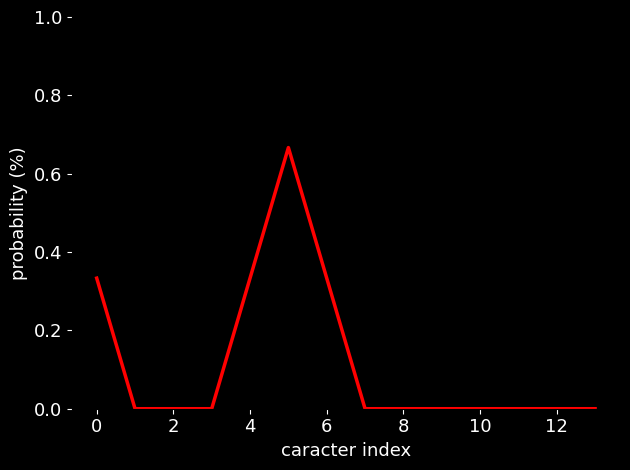

In [4]:
probability = 1. - partial_matrix[-1, 1:] / len(hypothesis)
plot(probability, ylim = (0, 1), xlabel = "caracter index", ylabel = "probability (%)")